## Pong with Policy Gradient

in Pong the player controls the right paddle, 
for each point scored by the AI (the in-game AI, not the player) you get -1 reward,
for each point scored by the player you get +1 reward
the game ends when either get 21 points

the code below is taken from: https://gist.github.com/s-gv/b13974f896c7baf81ea3a83cf1af4a66

In [31]:
import gym
import numpy as np
import random
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [32]:
env = gym.make('PongNoFrameskip-v4')
env.reset();

## the environments supports 6 actions, but the code below uses only 2 possible actions (left and right)

In [33]:
env.action_space

Discrete(6)

In [34]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

## let's see the game being played by a random player

In [29]:
state = env.reset()

screens = []

for t in range(190000):
    
    
    next_state , reward, done, info = env.step(env.action_space.sample())
    screens.append(next_state)
    
    if done:
        break

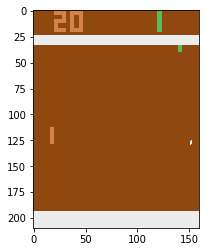

In [30]:
for i, screen in enumerate( screens ):
    if not i % 5 == 0:
        continue
    clear_output(wait=True)
    plt.imshow(screen)
    plt.show()

## now we construct the neural network that determines the action based on the state

## below we will review each of its functions, so keep reading

In [ ]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()

        self.gamma = 0.99
        self.eps_clip = 0.1

        self.layers = nn.Sequential(
            nn.Linear(6000*2, 512), nn.ReLU(),
            nn.Linear(512, 2),
        )
    
    def state_to_tensor(self, I):
        """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
        if I is None:
            return torch.zeros(1, 6000)
        I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
        I = I[::2,::2,0] # downsample by factor of 2.
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
        return torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0)

    def pre_process(self, x, prev_x):
        #return self.state_to_tensor(x) - self.state_to_tensor(prev_x)
        return torch.cat([self.state_to_tensor(x), self.state_to_tensor(prev_x)], dim=1)

    def convert_action(self, action):
        return action + 2

    def forward(self, d_obs, action=None, action_prob=None, advantage=None, deterministic=False):
        if action is None:
            with torch.no_grad():
                logits = self.layers(d_obs)
                if deterministic:
                    action = int(torch.argmax(logits[0]).detach().cpu().numpy())
                    action_prob = 1.0
                else:
                    c = torch.distributions.Categorical(logits=logits)
                    action = int(c.sample().cpu().numpy()[0])
                    action_prob = float(c.probs[0, action].detach().cpu().numpy())
                return action, action_prob
        '''
        # policy gradient (REINFORCE)
        logits = self.layers(d_obs)
        loss = F.cross_entropy(logits, action, reduction='none') * advantage
        return loss.mean()
        '''

        # PPO
        vs = np.array([[1., 0.], [0., 1.]])
        ts = torch.FloatTensor(vs[action.cpu().numpy()])
        
        logits = self.layers(d_obs)
        r = torch.sum(F.softmax(logits, dim=1) * ts, dim=1) / action_prob
        loss1 = r * advantage
        loss2 = torch.clamp(r, 1-self.eps_clip, 1+self.eps_clip) * advantage
        loss = -torch.min(loss1, loss2)
        loss = torch.mean(loss)

        return loss

policy = Policy()

## first let's look at the preprocessing

the code turns the image to black and white, and removes the unused top and bottom
(and then flattens the image to a vector of size 6000)

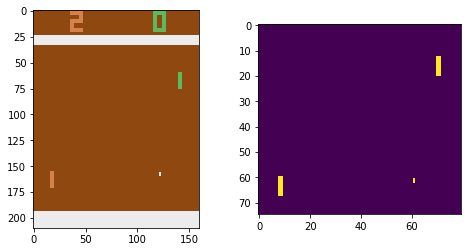

In [46]:
state = env.reset()

for i in range(500):
    state, _ , _ , _ = env.step( env.action_space.sample() )
    
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(state)


def transform_image(I):
    I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    I = I[::2,::2,0] # downsample by factor of 2.
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1
    #in the policy network, the preprocess function flattens the image to a vector
    return I

ax[1].imshow(transform_image(state))

## if we use the forward pass of the neural network to just provide a state, it will give us an action to do, and the probablity (under the current network weights) to do it

## during gameplay, we save this (state, action, action_prob, next state) information

In [47]:
state = env.reset()
next_state, _ , _ , _ = env.step( env.action_space.sample() )

combined_state = policy.pre_process(next_state, state)

action, action_prob = policy(combined_state)

print('action ',action, ' probability ', action_prob)

action  0  probability  0.5093664526939392


## after we play a few games, we look at the reward history, and then "go back in time" and compute the discounted future rewards for each time step

In [84]:
d_obs_history, action_history, action_prob_history, reward_history = [], [], [], []

obs, prev_obs = env.reset(), None
#play one game
for t in range(190000):
        

    d_obs = policy.pre_process(obs, prev_obs)
    with torch.no_grad():
        action, action_prob = policy(d_obs)

    prev_obs = obs
    obs, reward, done, info = env.step(policy.convert_action(action))

    d_obs_history.append(d_obs)
    action_history.append(action)
    action_prob_history.append(action_prob)
    reward_history.append(reward)

    if done:
        break

# compute future rewards
R = 0
discounted_rewards = []

for r in reward_history[::-1]:
    if r != 0: R = 0 # scored/lost a point in pong, so reset reward sum
    R = r + policy.gamma * R
    discounted_rewards.insert(0, R)

## in the plot below we see the rewards +1/-1 for scoring points, and the discounted future rewards computed once the game was over

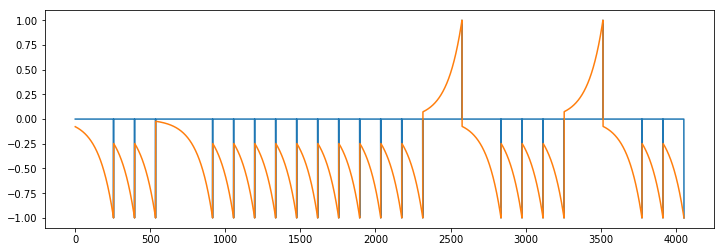

In [85]:
fig,ax = plt.subplots(figsize=(12,4))

ax.plot(reward_history)
ax.plot(discounted_rewards)

## given the future rewards, we can compute the "advantage" of a particular action, and that will be the weight given to it, to either increase or decrease it's probablity

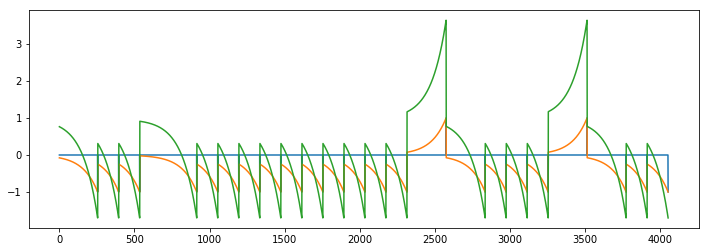

In [86]:
discounted_rewards = np.array(discounted_rewards)
advantage = (discounted_rewards - discounted_rewards.mean()) / discounted_rewards.std()

fig,ax = plt.subplots(figsize=(12,4))

ax.plot(reward_history)
ax.plot(discounted_rewards)
ax.plot(advantage)

## the next step is to compute for each (state,action, action_prob) the weighted loss, this is done internally in the neural network forward, let's break it down:

In [87]:
#turn everything to tensors
d_obs_history = torch.cat(d_obs_history,0)
action_history = torch.LongTensor(action_history)
action_prob_history = torch.FloatTensor(action_prob_history)
advantage = torch.FloatTensor(advantage)

#first get the network output for each of the states in the history
logits = policy.layers(d_obs_history)

# we have 2 possible actions, left and right. 
# this code creates a column of [0,1] or [1,0], based on which action was taken

vs = np.array([[1., 0.], [0., 1.]])
ts = torch.FloatTensor(vs[action_history.cpu().numpy()])
        
#next we take a softmax of each neural network output, turning it to probablities that sum to 1
#and then divide by the action probablity that it had when the action was originally taken
r = torch.sum(F.softmax(logits, dim=1) * ts, dim=1) / action_prob_history

#clip the ratio between action probablities, to not make changes to the network that are too large
#then compute the loss
loss1 = r * advantage
loss2 = torch.clamp(r, 1-policy.eps_clip, 1+policy.eps_clip) * advantage
loss = -torch.min(loss1, loss2)
loss = torch.mean(loss)

print(loss)

tensor(5.1728e-09, grad_fn=<MeanBackward1>)


## now let's put it all together  
## and start the play games / train cycle

after training for a few minutes you should see the agent slowly improving and increasing the number of points it scores in each game. (this also means the games go on for longer, since the agent does not lose so fast)

after you get bored of training, you can watch the agent play in the cells below

in the plot that gets updated after every 10 games, you see the number of points scored by the agent

In [98]:
policy = Policy()
policy.train()

Policy(
  (layers): Sequential(
    (0): Linear(in_features=12000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

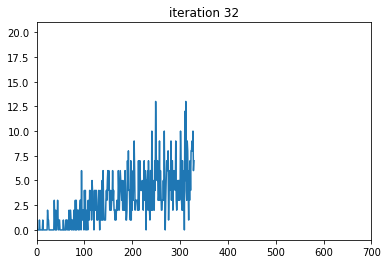

In [ ]:
opt = torch.optim.Adam(policy.parameters(), lr=1e-3)

points_scored_per_game = []

reward_sum_running_avg = None
for it in range(100000):
    d_obs_history, action_history, action_prob_history, reward_history = [], [], [], []
    for ep in range(10):
        obs, prev_obs = env.reset(), None
        points_in_game = 0
        for t in range(190000):
            

            d_obs = policy.pre_process(obs, prev_obs)
            with torch.no_grad():
                action, action_prob = policy(d_obs)
            
            prev_obs = obs
            obs, reward, done, info = env.step(policy.convert_action(action))
            
            d_obs_history.append(d_obs)
            action_history.append(action)
            action_prob_history.append(action_prob)
            reward_history.append(reward)
            
            if reward > 0:
                points_in_game+=1
            
            if done:
                points_scored_per_game.append(points_in_game)
                break
    
    # compute advantage
    R = 0
    discounted_rewards = []

    for r in reward_history[::-1]:
        if r != 0: R = 0 # scored/lost a point in pong, so reset reward sum
        R = r + policy.gamma * R
        discounted_rewards.insert(0, R)

    discounted_rewards = torch.FloatTensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / discounted_rewards.std()
    
    
    clear_output(wait=True)
    plt.title('iteration '+str(it))
    plt.plot(points_scored_per_game)
    plt.xlim(0,700)
    plt.ylim(-1,21)
    plt.show()
    
    # update policy
    for _ in range(5):
        n_batch = 24576
        idxs = random.sample(range(len(action_history)), n_batch)
        d_obs_batch = torch.cat([d_obs_history[idx] for idx in idxs], 0)
        action_batch = torch.LongTensor([action_history[idx] for idx in idxs])
        action_prob_batch = torch.FloatTensor([action_prob_history[idx] for idx in idxs])
        advantage_batch = torch.FloatTensor([discounted_rewards[idx] for idx in idxs])
        
              
        opt.zero_grad()
        loss = policy(d_obs_batch, action_batch, action_prob_batch, advantage_batch)
        loss.backward()
        opt.step()
    if it % 5 == 0:
        torch.save(policy.state_dict(), 'params.ckpt')

In [19]:
policy.eval()

screens = []

obs, prev_obs = env.reset(), None
for t in range(190000):
    #env.render()
    
    d_obs = policy.pre_process(obs, prev_obs)
    with torch.no_grad():
        action, action_prob = policy(d_obs)

    prev_obs = obs
    obs, reward, done, info = env.step(policy.convert_action(action))
    screens.append(obs)
    
    if done:
        break

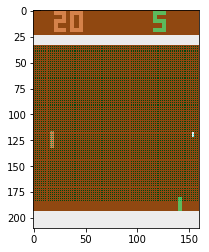

In [20]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

for i, screen in enumerate( screens ):
    if not i % 5 == 0:
        continue
    clear_output(wait=True)
    plt.imshow(screen)
    plt.show()